<a href="https://colab.research.google.com/github/dangduong2806/google-colab/blob/main/Bert-tiny.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
from google.colab import files
uploaded = files.upload()

Saving best_model.weights.h5 to best_model.weights.h5


In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
import pandas as pd
import transformers
from tensorflow.keras.layers import Input, Dense, Lambda

In [3]:
df = pd.read_csv("colors1.csv")
df.head()

,name,red,green,blue
0,parakeet,174,182,87
1,saddle brown,88,52,1
2,cucumber crush,222,237,215
3,pool blue,134,194,201
4,distance,98,110,130


In [4]:
df["red"] = df["red"] / 255
df["green"] = df["green"] / 255
df["blue"] = df["blue"] / 255
df.head()

,name,red,green,blue
0,parakeet,0.682353,0.713725,0.341176
1,saddle brown,0.345098,0.203922,0.003922
2,cucumber crush,0.870588,0.929412,0.843137
3,pool blue,0.525490,0.760784,0.788235
4,distance,0.384314,0.431373,0.509804


In [5]:
X_texts = df['name'].astype(str).values
y_rgb = df[['red', 'green', 'blue']].values

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
# Tách train/val
X_train, X_val, y_train, y_val = train_test_split(
    X_texts, y_rgb, test_size=0.2, shuffle = True, random_state=42
)

In [13]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("prajjwal1/bert-tiny")
def tokenize_text(texts):
    texts = list(texts)
    encodings = tokenizer(texts, padding=True, truncation=True, return_tensors="tf")
    return {
        "input_ids": encodings["input_ids"],
        "attention_mask": encodings["attention_mask"],
        "token_type_ids": encodings["token_type_ids"]
    }

In [17]:
from transformers import TFAutoModel
def create_bert_to_rgb_model():
    bert = TFAutoModel.from_pretrained('prajjwal1/bert-tiny', from_pt=True)
    # for layer in bert.layers:
    #     layer.trainable = False  # freeze toàn bộ BERT

    bert.trainable = False

    input_ids = tf.keras.Input(shape=(None,), dtype=tf.int32, name="input_ids")
    attention_mask = tf.keras.Input(shape=(None,), dtype=tf.int32, name="attention_mask")

    # Combined Lambda layer that does both BERT call and CLS extraction
    cls_token = tf.keras.layers.Lambda(
        lambda x: bert(input_ids=x[0], attention_mask=x[1]).last_hidden_state[:, 0, :],
        output_shape=(128,)
    )([input_ids, attention_mask])

    # Chỉ train lớp này
    x = tf.keras.layers.Dense(128, activation="relu")(cls_token)
    x = tf.keras.layers.Dense(3, activation="sigmoid")(x)  # sigmoid vì RGB chuẩn hóa [0, 1]

    model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=x)
    return model

In [18]:
model = create_bert_to_rgb_model()

pytorch_model.bin:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['bert.embeddings.position_ids', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the 

In [19]:
train_tokens = tokenize_text(X_train)
val_tokens = tokenize_text(X_val)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [20]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="mse",
    metrics=["mae"]
)

In [22]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    'best_model_bert_tiny.weights.h5',  # Must end with .weights.h5
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    mode='min',
    verbose=1
)


In [23]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Khởi tạo callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',      # theo dõi val_loss (có thể là 'val_accuracy' tùy bài toán)
    factor=0.5,              # mỗi lần giảm thì LR = LR * factor
    patience=5,              # nếu sau 5 epoch val_loss không cải thiện thì giảm LR
    min_lr=1e-6,             # learning rate nhỏ nhất có thể giảm tới
    verbose=1                # in log khi learning rate thay đổi
)

In [24]:
history = model.fit(
    train_tokens,
    y_train,
    validation_data=(val_tokens, y_val),
    epochs=100,
    batch_size=16,
    shuffle = True,
    callbacks=[
        checkpoint, reduce_lr, tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    ]
)


Epoch 1/100
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0702 - mae: 0.2181
Epoch 1: val_loss improved from inf to 0.06004, saving model to best_model_bert_tiny.weights.h5
718/718 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.0702 - mae: 0.2180 - val_loss: 0.0600 - val_mae: 0.2049 - learning_rate: 1.0000e-04
Epoch 2/100
701/718 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0602 - mae: 0.2045
Epoch 2: val_loss improved from 0.06004 to 0.05787, saving model to best_model_bert_tiny.weights.h5
718/718 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0602 - mae: 0.2045 - val_loss: 0.0579 - val_mae: 0.2011 - learning_rate: 1.0000e-04
Epoch 3/100
717/718 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0588 - mae: 0.2014
Epoch 3: val_loss improved from 0.05787 to 0.05658, saving model to best_model_bert_tiny.weights.h5
718/718 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0588 - mae: 0.2014 - val_loss: 0.0566 - val_mae: 0.1985 - learning_rate: 1.0000e-04
Epoch 4/100
704/718 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

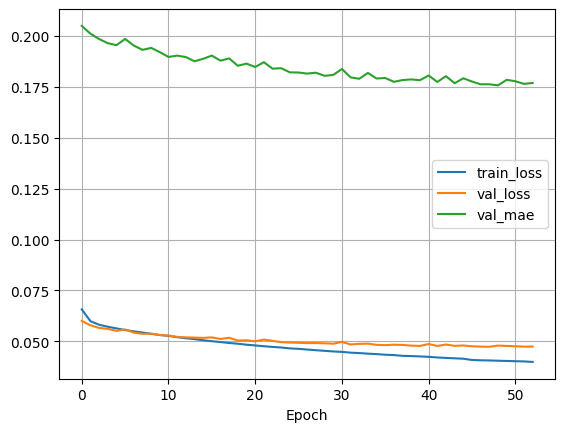

In [25]:

import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['val_mae'], label='val_mae')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
def scale(n):
    return int(n * 255)

In [27]:
def plot_rgb(rgb):
    data = [[rgb]]
    plt.figure(figsize=(2, 2))
    plt.imshow(data, interpolation='nearest')
    plt.show()

In [28]:
def predict(name):
    name = name.lower()
    # Tokenize input (chuẩn cho BERT)
    encoded = tokenizer(
        name,
        padding='max_length',
        truncation=True,
        max_length=16,  # hoặc dài hơn nếu bạn muốn
        return_tensors='tf'
    )

    # Dự đoán RGB
    pred = model.predict({
        "input_ids": encoded["input_ids"],
        "attention_mask": encoded["attention_mask"]
    }, verbose=0)[0]  # lấy [0] vì chỉ có 1 mẫu

    # Scale về 0-255
    r, g, b = scale(pred[0]), scale(pred[1]), scale(pred[2])

    print(name + ',', 'R,G,B:', r, g, b)
    plot_rgb(pred)

Lemon Yellow
lemon yellow, R,G,B: 233 218 64


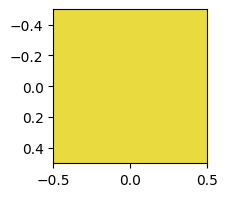

In [29]:
n = input()
predict(n)

Sky Blue
sky blue, R,G,B: 111 196 217


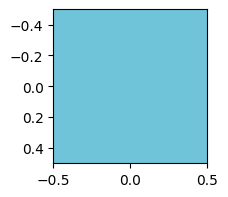

In [30]:
n = input()
predict(n)

Cucumber
cucumber, R,G,B: 190 179 155


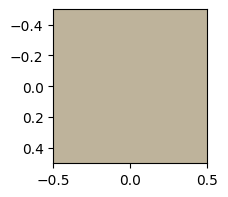

In [31]:
n = input()
predict(n)

Ocean
ocean, R,G,B: 92 146 156


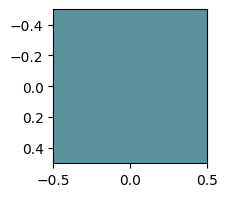

In [32]:
n = input()
predict(n)

Red
red, R,G,B: 160 80 62


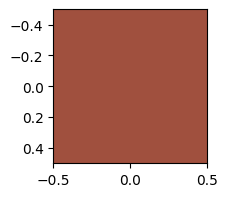

In [33]:
n = input()
predict(n)

Evaluate

In [34]:
X_train, X_val, y_train, y_val = train_test_split(
    X_texts, y_rgb, test_size=0.3, shuffle = True, random_state=42
)

In [35]:
model.load_weights("best_model_bert_tiny.weights.h5")

In [36]:
X_val_2 = tokenize_text(X_val)

In [37]:
y_pred = model.predict(X_val_2)

135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step


In [38]:
!pip install colormath

  Preparing metadata (setup.py) ... done
  Created wheel for colormath: filename=colormath-3.0.0-py3-none-any.whl size=39405 sha256=da7f6a250dfadaea80692aea7ba01f597542ff4a0a2984939adbde85f316dda6
  Stored in directory: /root/.cache/pip/wheels/f5/ce/f7/7039d7b57e1a27fc2f6bb2b2abed1be362eefece03caf2fb9a
Successfully built colormath


In [39]:
from colormath.color_objects import LabColor, sRGBColor
from colormath.color_conversions import convert_color
from colormath.color_diff import delta_e_cie2000
import numpy as np
if not hasattr(np, 'asscalar'):
    np.asscalar = lambda x: x.item()

def compute_ciede2000_each_point(y_true, y_pred):
    delta_e_list = []
    for true_rgb, pred_rgb in zip(y_true, y_pred):
        c1 = sRGBColor(*true_rgb, is_upscaled=True)
        c2 = sRGBColor(*pred_rgb, is_upscaled=True)
        lab1 = convert_color(c1, LabColor)
        lab2 = convert_color(c2, LabColor)
        delta_e = float(delta_e_cie2000(lab1, lab2))
        delta_e_list.append(delta_e)
    return delta_e_list

# Scale về [0, 255] nếu cần
y_true_scaled = np.clip(y_val * 255, 0, 255)
y_pred_scaled = np.clip(y_pred * 255, 0, 255)

delta_e_list = compute_ciede2000_each_point(y_true_scaled, y_pred_scaled)

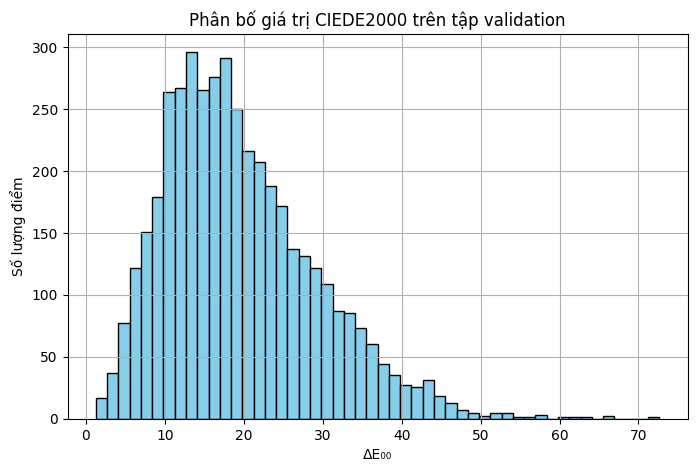

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(delta_e_list, bins=50, color='skyblue', edgecolor='black')
plt.title("Phân bố giá trị CIEDE2000 trên tập validation")
plt.xlabel("ΔE₀₀")
plt.ylabel("Số lượng điểm")
plt.grid(True)
plt.show()

In [41]:
results = model.evaluate(X_val_2, y_val)

135/135 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0470 - mae: 0.1758
